In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

# Define the SOM2D class as provided earlier
class SOM2D:
    def __init__(self, input_size, grid_size=(10, 10), initial_lr=0.2):
        self.grid_rows, self.grid_cols = grid_size
        self.weights = np.random.rand(self.grid_rows, self.grid_cols, input_size)
        self.initial_lr = initial_lr
        self.lr = initial_lr
        self.neighborhood_size = None  # Will be updated during training

    def train(self, X, epochs):
        max_neighborhood_size = max(self.grid_rows, self.grid_cols) / 2
        for epoch in range(epochs):
            # Decay neighborhood size and learning rate over time
            self.neighborhood_size = max(1, int(max_neighborhood_size * (1 - epoch / epochs)))
            self.lr = self.initial_lr * (1 - epoch / epochs)
            for x in X:
                self.update_weights(x)

    def update_weights(self, x):
        winner = self.find_winner(x)
        for i in range(self.grid_rows):
            for j in range(self.grid_cols):
                # Calculate the distance between the winner and node (i, j)
                distance = np.sqrt((winner[0] - i) ** 2 + (winner[1] - j) ** 2)
                if distance <= self.neighborhood_size:
                    influence = np.exp(-distance / (2 * (self.neighborhood_size ** 2)))
                    self.weights[i, j] += influence * self.lr * (x - self.weights[i, j])

    def find_winner(self, x):
        # Compute the distance between x and all nodes
        distances = np.linalg.norm(self.weights - x, axis=2)
        winner_index = np.unravel_index(np.argmin(distances), distances.shape)
        return winner_index

    def get_positions(self, X):
        positions = []
        for x in X:
            winner = self.find_winner(x)
            positions.append(winner)
        return positions


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

votes_flat = np.loadtxt('data_lab2/votes.dat', delimiter=',')

votes = votes_flat.reshape((349, 31))

# Load mpparty.dat
with open('data_lab2/mpparty.dat', 'r') as f:
    parties = [line.strip() for line in f.readlines()]
    
# Load mpsex.dat
with open('data_lab2/mpsex.dat', 'r') as f:
    genders = [line.strip() for line in f.readlines()]
    
# Load mpdistrict.dat
with open('data_lab2/mpdistrict.dat', 'r') as f:
    districts = [line.strip() for line in f.readlines()]
    
with open('data_lab2/mpnames.txt', 'r', encoding='iso-8859-1') as f:
    names = [line.strip() for line in f.readlines()]

# Verify the data dimensions
assert votes.shape == (349, 31), "Votes data should be 349x31."
assert len(parties) == 349, "There should be 349 party entries."
assert len(genders) == 349, "There should be 349 gender entries."
assert len(districts) == 349, "There should be 349 district entries."
assert len(names) == 349, "There should be 349 names."


In [17]:
# 2. Encoding Categorical Data

## 2.1. Encoding Genders

# Map '0' to 'Male' and '1' to 'Female'
gender_mapping = {'0': 'Male', '1': 'Female'}
genders_mapped = [gender_mapping.get(g, 'Unknown') for g in genders]

# Encode genders for visualization
gender_encoded = np.array([0 if g == 'Male' else 1 for g in genders_mapped])

## 2.2. Encoding Parties

# Check if party names are available; if not, treat numerical codes as categories
unique_party_codes = sorted(list(set(parties)))
print(f"Unique party codes: {unique_party_codes}")

# Create a mapping from party codes to integer indices for color-coding
party_to_int = {code: idx for idx, code in enumerate(unique_party_codes)}
party_encoded = np.array([party_to_int[party] for party in parties])

## 2.3. Encoding Districts

unique_district_codes = sorted(list(set(districts)))
print(f"Unique district codes: {unique_district_codes}")

# Create a mapping from district codes to integer indices for color-coding
district_to_int = {code: idx for idx, code in enumerate(unique_district_codes)}
district_encoded = np.array([district_to_int[district] for district in districts])


Unique party codes: ['0', '1', '2', '3', '4', '5', '6', '7']
Unique district codes: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '4', '5', '6', '7', '8', '9']


In [18]:
input_size = votes.shape[1]  # 31 votes
som_grid_size = (10, 10)
som = SOM2D(input_size=input_size, grid_size=som_grid_size, initial_lr=0.2)

# Normalize the voting data
# Since votes are 0, 0.5, 1, normalization can help
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
votes_normalized = scaler.fit_transform(votes)

# Train SOM
epochs = 400  # You can adjust the number of epochs
som.train(votes_normalized, epochs=epochs)


In [19]:
# 4. Mapping MPs to the SOM Grid

positions = som.get_positions(votes_normalized)  # List of (row, col) tuples
positions = np.array(positions)
print(f"Positions shape: {positions.shape}")  # Should be (349, 2)

x_coords = positions[:, 1]  # Column index
y_coords = positions[:, 0]  # Row index

Positions shape: (349, 2)


/var/folders/9d/06ymmlt92jl6wf2kyv5twvzw0000gp/T/ipykernel_60121/1669234774.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_parties)


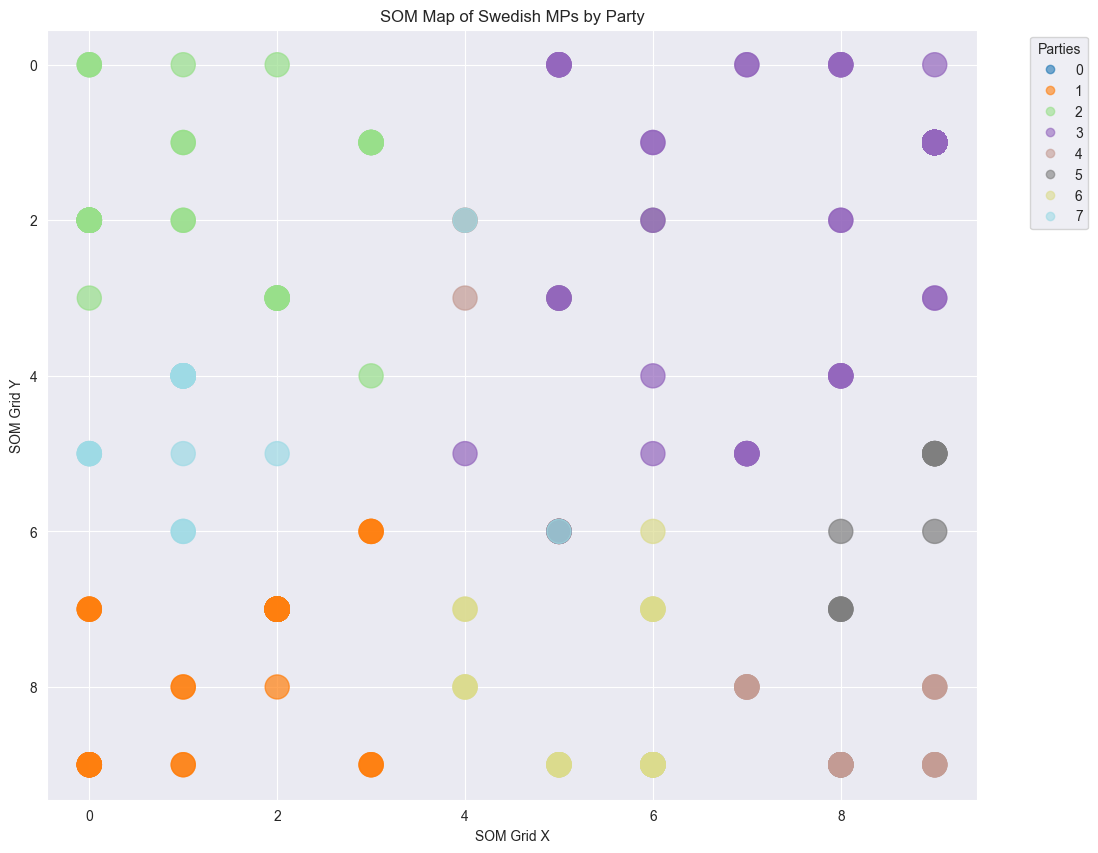

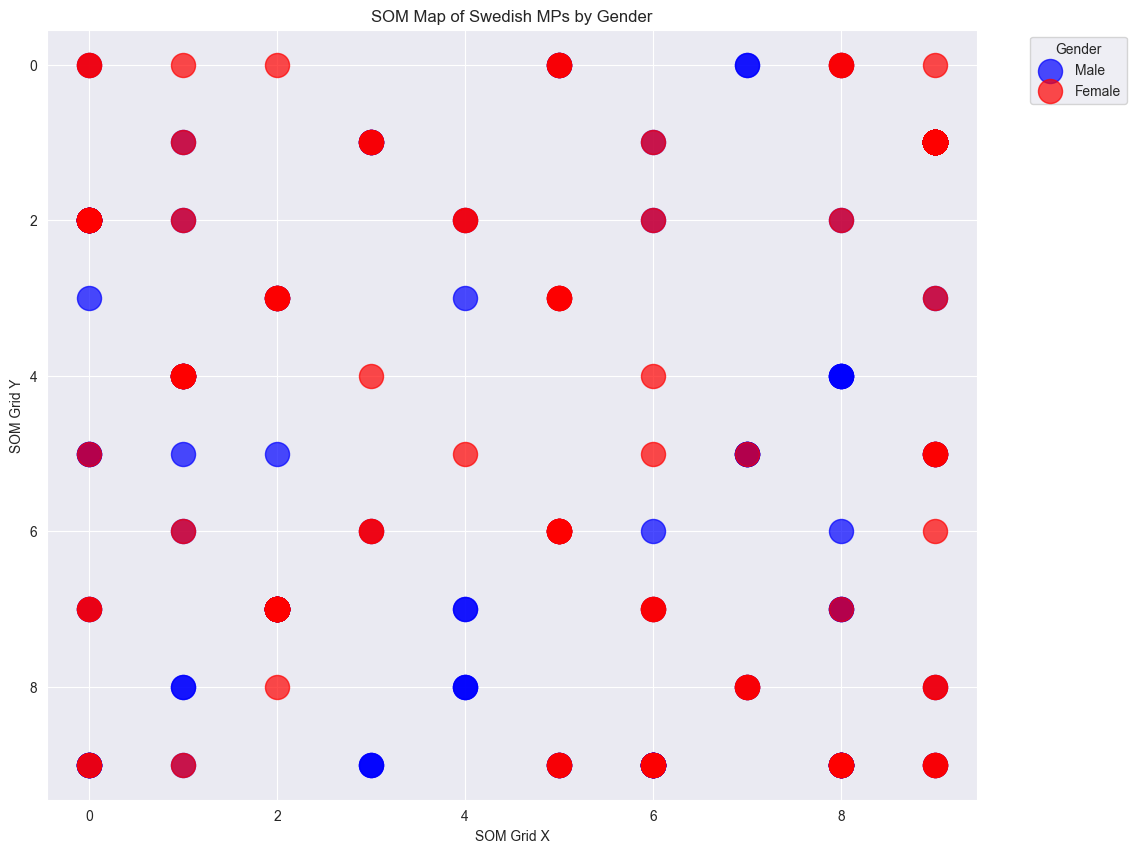

/var/folders/9d/06ymmlt92jl6wf2kyv5twvzw0000gp/T/ipykernel_60121/1669234774.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_district = cm.get_cmap('tab20', num_districts)


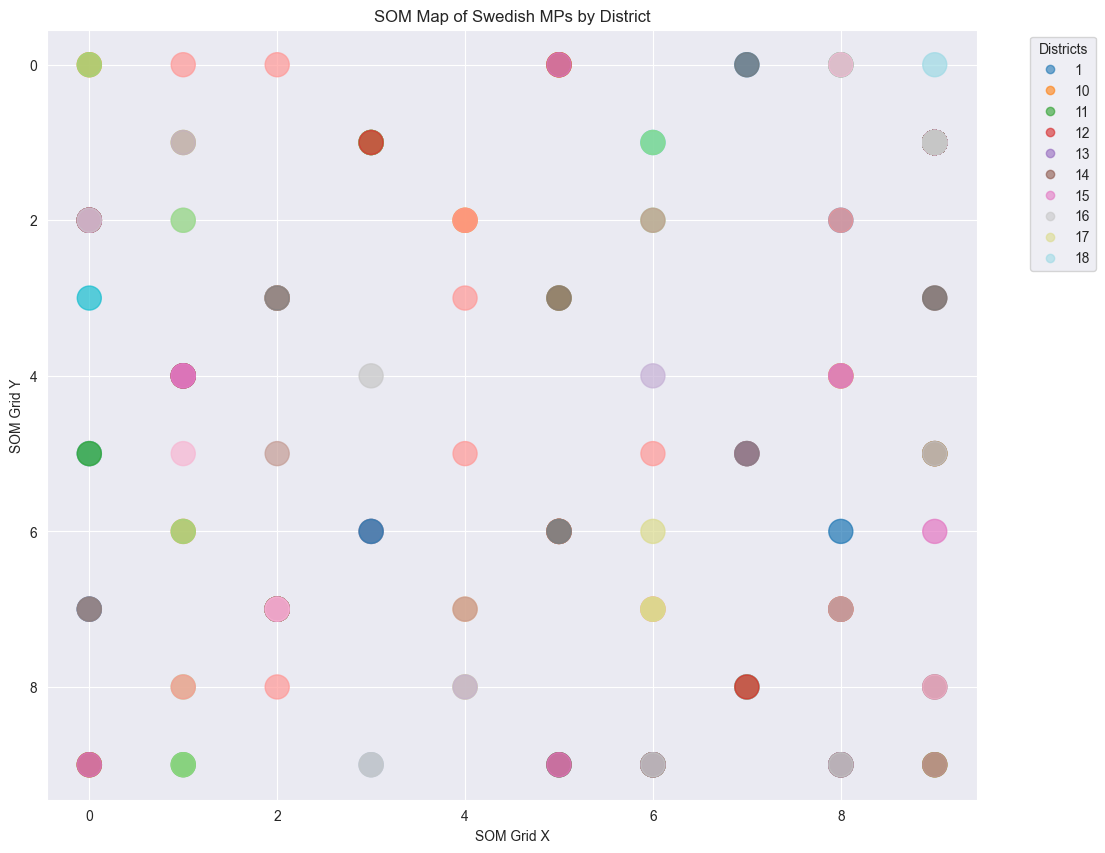

In [20]:
# 5. Visualization and Interpretation

## 5.1. Visualization by Party

num_parties = len(unique_party_codes)
cmap = cm.get_cmap('tab20', num_parties)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(x_coords, y_coords, c=party_encoded, cmap=cmap, s=300, alpha=0.7)

# Create a legend with party codes
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
legend_labels = unique_party_codes
plt.legend(handles, legend_labels, title="Parties", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('SOM Map of Swedish MPs by Party')
plt.xlabel('SOM Grid X')
plt.ylabel('SOM Grid Y')
plt.gca().invert_yaxis()  # To have (0,0) at top-left
plt.grid(True)
plt.show()

## 5.2. Visualization by Gender

gender_colors = ['blue', 'red']  # Male - blue, Female - red

plt.figure(figsize=(12, 10))
for gender in [0, 1]:
    idx = gender_encoded == gender
    plt.scatter(x_coords[idx], y_coords[idx], 
                c=gender_colors[gender], label='Male' if gender == 0 else 'Female', 
                s=300, alpha=0.7)

plt.title('SOM Map of Swedish MPs by Gender')
plt.xlabel('SOM Grid X')
plt.ylabel('SOM Grid Y')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

## 5.3. Visualization by District

num_districts = len(unique_district_codes)
cmap_district = cm.get_cmap('tab20', num_districts)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(x_coords, y_coords, c=district_encoded, cmap=cmap_district, s=300, alpha=0.7)

# Create a legend with district codes
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
legend_labels = unique_district_codes
plt.legend(handles, legend_labels, title="Districts", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('SOM Map of Swedish MPs by District')
plt.xlabel('SOM Grid X')
plt.ylabel('SOM Grid Y')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()
